In [ ]:
!mkdir -p /content/kitti
!wget -P /content/kitti/ https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip
!wget -P /content/kitti/ https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip
!unzip /content/kitti/data_object_image_2.zip -d /content/kitti/
!unzip /content/kitti/data_object_label_2.zip -d /content/kitti/

--2025-05-03 10:55:18--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.171.177, 3.5.135.10, 52.219.72.203, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.171.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12569945557 (12G) [application/zip]
Saving to: ‘/content/kitti/data_object_image_2.zip’

data_object_image_2 100%[===================>]  11.71G  13.0MB/s    in 33m 1s  

2025-05-03 11:28:20 (6.05 MB/s) - ‘/content/kitti/data_object_image_2.zip’ saved [12569945557/12569945557]

--2025-05-03 11:28:20--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.137.12, 52.219.171.105, 3.5.137.116, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.137.12|:443... connected.
HTTP request se

In [ ]:
import os
import random
import shutil
from pathlib import Path
from collections import Counter
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

import tensorflow as tf

import torch
import torchvision
from torch.optim import SGD
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


2025-05-03 11:46:22.498477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746272782.688037      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746272782.745220      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:

image_dir = "/content/kitti/training/image_2"
label_dir = "/content/kitti/training/label_2"
output_image_dir = "/content/kitti/augmented/image_2"
output_label_dir = "/content/kitti/augmented/label_2"

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

target_classes = ['Pedestrian', 'Cyclist']


transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.MotionBlur(p=0.2),
    A.Rotate(limit=5, p=0.3),
    A.RandomScale(scale_limit=0.2, p=0.3),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

def parse_label_file(label_path):
    bboxes = []
    class_labels = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls = parts[0]
            if cls in target_classes:
                x1 = float(parts[4])
                y1 = float(parts[5])
                x2 = float(parts[6])
                y2 = float(parts[7])
                bboxes.append([x1, y1, x2, y2])
                class_labels.append(cls)
    return bboxes, class_labels

image_paths = sorted(glob.glob(os.path.join(image_dir, '*.png')))

aug_count = 0
for img_path in image_paths:
    filename = os.path.basename(img_path).replace('.png', '')
    label_path = os.path.join(label_dir, f"{filename}.txt")
    
    if not os.path.exists(label_path):
        continue

    bboxes, class_labels = parse_label_file(label_path)
    if len(bboxes) == 0:
        continue

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for i in range(2):  # عدد augmentations لكل صورة
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_img = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['class_labels']

        if len(aug_bboxes) == 0:
            continue

        new_filename = f"{filename}_aug_{i}"
        output_img_path = os.path.join(output_image_dir, f"{new_filename}.png")
        output_lbl_path = os.path.join(output_label_dir, f"{new_filename}.txt")

        cv2.imwrite(output_img_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

        with open(output_lbl_path, 'w') as f:
            for bbox, label in zip(aug_bboxes, aug_labels):
                x1, y1, x2, y2 = bbox
                f.write(f"{label} 0 0 0 {x1:.2f} {y1:.2f} {x2:.2f} {y2:.2f} 0 0 0 0 0 0 0\n")

        aug_count += 1

print(f"✅ Augmented {aug_count} new images with Cyclist and Pedestrian.")


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


✅ Augmented 4972 new images with Cyclist and Pedestrian.


In [ ]:

image_dir = "/content/kitti/training/image_2"
label_dir = "/content/kitti/training/label_2"
output_image_dir = "/content/kitti/aug2/image_2"
output_label_dir = "/content/kitti/aug2/label_2"

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

target_classes = ['Pedestrian', 'Cyclist']
aug_target = {'Pedestrian': 8000, 'Cyclist': 11000}
aug_counters = defaultdict(int)
aug_count = 0

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.MotionBlur(p=0.2),
    A.Rotate(limit=5, p=0.3),
    A.RandomScale(scale_limit=0.2, p=0.3),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


def parse_label_file(label_path):
    bboxes = []
    class_labels = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls = parts[0]
            if cls in target_classes:
                x1 = float(parts[4])
                y1 = float(parts[5])
                x2 = float(parts[6])
                y2 = float(parts[7])
                bboxes.append([x1, y1, x2, y2])
                class_labels.append(cls)
    return bboxes, class_labels


image_paths = sorted(glob.glob(os.path.join(image_dir, '*.png')))

for img_path in image_paths:
    filename = os.path.basename(img_path).replace('.png', '')
    label_path = os.path.join(label_dir, f"{filename}.txt")

    if not os.path.exists(label_path):
        continue

    bboxes, class_labels = parse_label_file(label_path)
    if len(bboxes) == 0:
        continue

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    tries = 0
    max_tries = 30  

    while tries < max_tries:
        tries += 1

        
        try:
            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        except TypeError:
            augmented = transform(**{
                'image': image,
                'bboxes': bboxes,
                'class_labels': class_labels
            })

        aug_img = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['class_labels']

        if len(aug_bboxes) == 0:
            continue

       
        contains_needed_class = any(
            lbl in target_classes and aug_counters[lbl] < aug_target[lbl]
            for lbl in aug_labels
        )
        if not contains_needed_class:
            continue

        
        new_filename = f"{filename}_aug_{aug_count}"
        output_img_path = os.path.join(output_image_dir, f"{new_filename}.png")
        output_lbl_path = os.path.join(output_label_dir, f"{new_filename}.txt")
        cv2.imwrite(output_img_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

        
        with open(output_lbl_path, 'w') as f:
            for bbox, label in zip(aug_bboxes, aug_labels):
                x1, y1, x2, y2 = bbox
                f.write(f"{label} 0 0 0 {x1:.2f} {y1:.2f} {x2:.2f} {y2:.2f} 0 0 0 0 0 0 0\n")
                if label in target_classes and aug_counters[label] < aug_target[label]:
                    aug_counters[label] += 1

        aug_count += 1

        if all(aug_counters[cls] >= aug_target[cls] for cls in target_classes):
            break

    if all(aug_counters[cls] >= aug_target[cls] for cls in target_classes):
        break

print(f"✅ Augmentation completed.")
print(f"👣 Pedestrian: {aug_counters['Pedestrian']}/{aug_target['Pedestrian']}")
print(f"🚴 Cyclist: {aug_counters['Cyclist']}/{aug_target['Cyclist']}")


✅ Augmentation completed.
👣 Pedestrian: 8000/8000
🚴 Cyclist: 11000/11000


In [ ]:


aug_images_dir = '/content/kitti/aug2/image_2/'
aug_labels_dir = '/content/kitti/aug2/label_2/'


target_images_dir = '/content/kitti/training/image_2/'
target_labels_dir = '/content/kitti/training/label_2/'


os.makedirs(target_images_dir, exist_ok=True)
os.makedirs(target_labels_dir, exist_ok=True)


aug_image_files = glob(os.path.join(aug_images_dir, '*.png'))
for file_path in aug_image_files:
    shutil.move(file_path, os.path.join(target_images_dir, os.path.basename(file_path)))


aug_label_files = glob(os.path.join(aug_labels_dir, '*.txt'))
for file_path in aug_label_files:
    shutil.move(file_path, os.path.join(target_labels_dir, os.path.basename(file_path)))

print(f"✅ Successfully moved {len(aug_image_files)} images and {len(aug_label_files)} label files to the training folder.")


✅ Successfully moved 10445 images and 10445 label files to the training folder.


In [ ]:


aug_images_dir = '/content/kitti/augmented/image_2/'
aug_labels_dir = '/content/kitti/augmented/label_2/'

target_images_dir = '/content/kitti/training/image_2/'
target_labels_dir = '/content/kitti/training/label_2/'

os.makedirs(target_images_dir, exist_ok=True)
os.makedirs(target_labels_dir, exist_ok=True)

aug_image_files = glob(os.path.join(aug_images_dir, '*.png'))
for file_path in aug_image_files:
    shutil.move(file_path, os.path.join(target_images_dir, os.path.basename(file_path)))

aug_label_files = glob(os.path.join(aug_labels_dir, '*.txt'))
for file_path in aug_label_files:
    shutil.move(file_path, os.path.join(target_labels_dir, os.path.basename(file_path)))

print(f"✅ {len(aug_image_files)} images and {len(aug_label_files)} label files have been moved to the training folder.")


✅ 4972 images and 4972 label files have been moved to the training folder.


In [ ]:
#  Load image and label paths
all_images = sorted(glob('/content/kitti/training/image_2/*.png'))
all_labels = sorted(glob('/content/kitti/training/label_2/*.txt'))

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

print("Train images:", len(train_imgs))
print("Val images:", len(val_imgs))
print(len(train_labels))



Train images: 18316
Val images: 4580
18316


In [8]:
# prompt: write code to know classes that exist in dataset

classes = []
for path in train_labels:
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            data = line.strip().split()
            if data:  # تأكد إن السطر مش فاضي
                classes.append(data[0])

# عدّ الكلاسات
class_counts = Counter(classes)
print(class_counts)

Counter({'Car': 23067, 'Pedestrian': 22550, 'Cyclist': 12717, 'DontCare': 9002, 'Van': 2316, 'Truck': 889, 'Misc': 772, 'Tram': 414, 'Person_sitting': 167})


In [9]:
# prompt: range clasees from big to small

# Sort the class counts from largest to smallest
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

sorted_class_counts

{'Car': 23067,
 'Pedestrian': 22550,
 'Cyclist': 12717,
 'DontCare': 9002,
 'Van': 2316,
 'Truck': 889,
 'Misc': 772,
 'Tram': 414,
 'Person_sitting': 167}

Counter({'Car': 23067, 'Pedestrian': 22550, 'Cyclist': 12717})


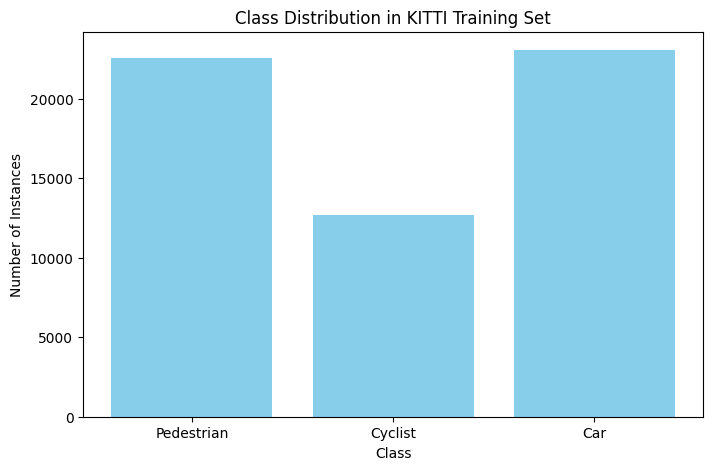

In [ ]:
class_counter = Counter()

for label_path in train_labels:
    with open(label_path, 'r') as f:
        for line in f.readlines():
            class_name = line.strip().split()[0]
            if class_name in ["Car", "Pedestrian", "Cyclist"]:
                class_counter[class_name] += 1

print(class_counter)

plt.figure(figsize=(8, 5))
plt.bar(class_counter.keys(), class_counter.values(), color='skyblue')
plt.title('Class Distribution in KITTI Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.show()

Counter({'Car': 23067, 'Pedestrian': 22550, 'Cyclist': 12717})


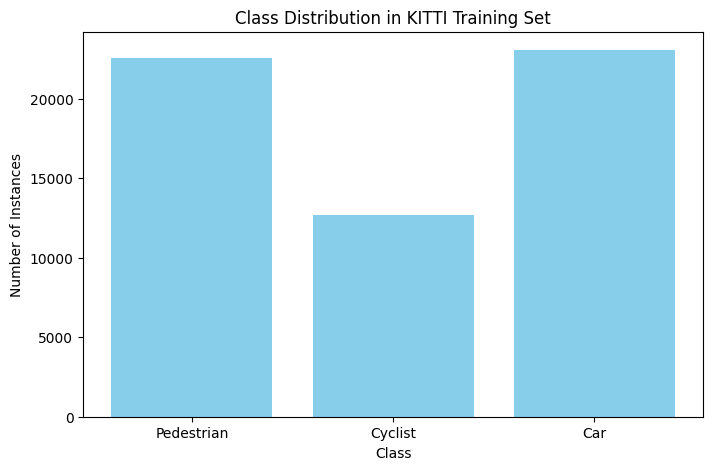

In [ ]:
class_counter = Counter()

for label_path in train_labels:
    with open(label_path, 'r') as f:
        for line in f.readlines():
            class_name = line.strip().split()[0]
            if class_name in ["Car", "Pedestrian", "Cyclist"]:
                class_counter[class_name] += 1

print(class_counter)

plt.figure(figsize=(8, 5))
plt.bar(class_counter.keys(), class_counter.values(), color='skyblue')
plt.title('Class Distribution in KITTI Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.show()

Average: [1237.384  373.652]
Minimum image size: [999 301]
Maximum image size: [1474  445]


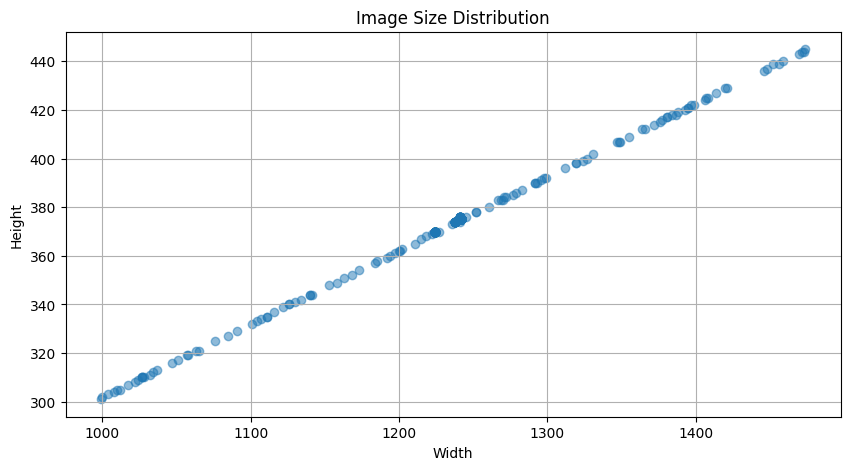

In [ ]:
image_sizes = []

for img_path in train_imgs[:500]:  
    with Image.open(img_path) as img:
        image_sizes.append(img.size)  

image_sizes = np.array(image_sizes)

print("Average:", np.mean(image_sizes, axis=0))
print("Minimum image size:", np.min(image_sizes, axis=0))
print("Maximum image size:", np.max(image_sizes, axis=0))

plt.figure(figsize=(10,5))
plt.scatter(image_sizes[:,0], image_sizes[:,1], alpha=0.5)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Size Distribution')
plt.grid(True)
plt.show()

In [13]:
wrong_boxes = 0

for img_path, label_path in zip(train_imgs, train_labels):
    with Image.open(img_path) as img:
        width, height = img.size

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split(' ')
            class_name = parts[0]
            if class_name in ["Car", "Pedestrian", "Cyclist"]:
                xmin = float(parts[4])
                ymin = float(parts[5])
                xmax = float(parts[6])
                ymax = float(parts[7])

                if xmin >= xmax or ymin >= ymax or xmax > width or ymax > height:
                    wrong_boxes += 1

print(f"wrong box number {wrong_boxes}")


wrong box number 0


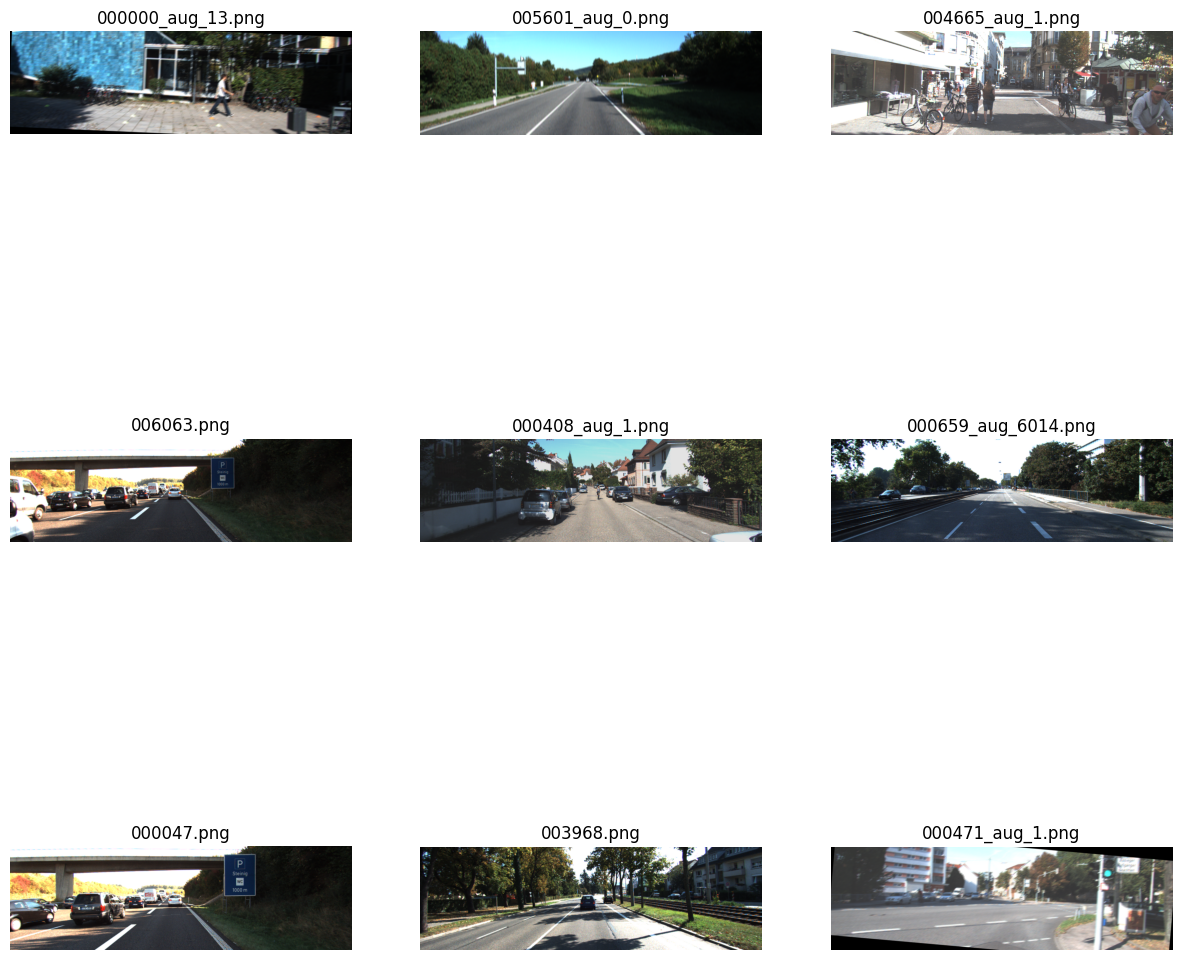

In [ ]:
import random

sample_paths = random.sample(train_imgs, 9)

plt.figure(figsize=(15,15))
for i, img_path in enumerate(sample_paths):
    img = Image.open(img_path)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path))
plt.show()


In [ ]:

class_map = {
    "Car": 1,
    "Pedestrian": 2,
    "Cyclist": 3
}

def load_image_and_labels(image_path, label_path):
    img = Image.open(image_path).convert("RGB")

    boxes = []
    labels = []

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split(' ')
            class_name = parts[0]
            if class_name not in class_map:
                continue  

            xmin = float(parts[4])
            ymin = float(parts[5])
            xmax = float(parts[6])
            ymax = float(parts[7])

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(class_map[class_name])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels

    return img, target


In [16]:
from torch.utils.data import Dataset

class KITTIDataset(Dataset):
    def __init__(self, image_paths, label_paths, transforms=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        img, target = load_image_and_labels(img_path, label_path)

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_paths)


In [17]:
print(len(train_imgs))

18316


In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
f
# تجهيز Transformations
transform = T.Compose([
    T.ToTensor(),  
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])


train_dataset = KITTIDataset(train_imgs, train_labels, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 3 + 1  # Car, Pedestrian, Cyclist + background

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 201MB/s] 


In [20]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Training on:", device)

Training on: cuda


In [ ]:
import torch.optim as optim

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [22]:
# Dataset و DataLoader للـ validation
val_dataset = KITTIDataset(val_imgs, val_labels, transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [27]:
!pip install torchmetrics


In [ ]:
import torchmetrics

def evaluate_map(model, data_loader, device):
    metric = torchmetrics.detection.mean_ap.MeanAveragePrecision()
    
    model.eval() 
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            predictions = model(images)

            for pred, target in zip(predictions, targets):
                boxes = pred['boxes']
                labels = pred['labels']
                scores = pred['scores']
                
                all_preds.append({"boxes": boxes, "labels": labels, "scores": scores})
                all_targets.append({"boxes": target['boxes'], "labels": target['labels']})
    
    # حساب المAP
    metric.update(all_preds, all_targets)
    return metric.compute()['map']


In [ ]:
num_epochs = 10  
patience = 8  
best_map = 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    lr_scheduler.step()

    # Evaluate mAP
    val_map = evaluate_map(model, val_loader, device=device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Val mAP: {val_map:.4f}")

    # Check for improvement
    if val_map > best_map:
        best_map = val_map
        epochs_no_improve = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
        print("-- Best model saved.")
    else:
        epochs_no_improve += 1
        print(f" **No improvement for {epochs_no_improve} epoch(s).")

    # Early stopping check
    if epochs_no_improve >= patience:
        print(f" Early stoppingg triggered at epoch {epoch+1}.")
        break


Epoch 1/10, Loss: 524.1191, Val mAP: 0.5800
-- Best model saved.
Epoch 2/10, Loss: 439.6875, Val mAP: 0.6369
-- Best model saved.
Epoch 3/10, Loss: 385.8807, Val mAP: 0.6476
-- Best model saved.
Epoch 4/10, Loss: 287.4471, Val mAP: 0.7012
-- Best model saved.
Epoch 5/10, Loss: 270.7033, Val mAP: 0.7091
-- Best model saved.
Epoch 6/10, Loss: 261.0939, Val mAP: 0.7129
-- Best model saved.
Epoch 7/10, Loss: 247.7954, Val mAP: 0.7141
-- Best model saved.
Epoch 8/10, Loss: 246.0050, Val mAP: 0.7148
-- Best model saved.
Epoch 9/10, Loss: 245.0106, Val mAP: 0.7141
 **No improvement for 1 epoch(s).
Epoch 10/10, Loss: 243.3006, Val mAP: 0.7150
-- Best model saved.


In [51]:
image_paths_testing = sorted(glob('/content/kitti/testing/image_2/*.png'))
label_paths_testing = sorted(glob('/content/kitti/testing/label_2/*.txt'))

print("Number of testing images:", len(image_paths_testing))


Number of testing images: 7518


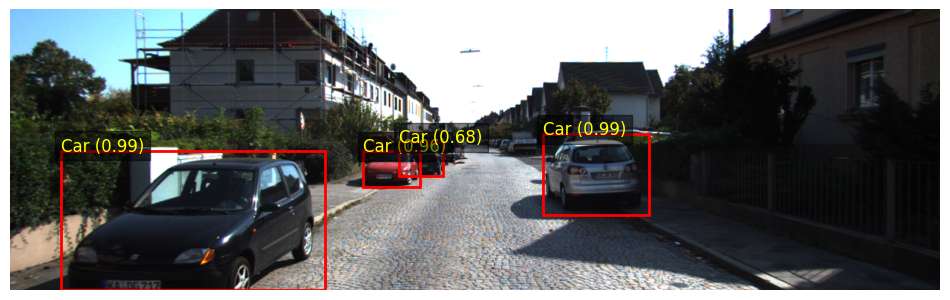

In [90]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from PIL import Image

# Define the CLASS_NAME_TO_ID mapping
CLASS_NAME_TO_ID = {
    1: "Car",
    2: "Pedestrian",
    3: "Cyclist"
}

test_image_path = image_paths_testing[75]
image = Image.open(test_image_path).convert("RGB")

# Apply same transform as training
img_tensor = transform(image).to(device)
model.eval()
with torch.no_grad():
    prediction = model([img_tensor])

def plot_prediction(image, prediction, threshold=0.5):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
        if score >= threshold:
            x1, y1, x2, y2 = box.cpu().numpy()
            # Get class name from the defined mapping
            class_name = CLASS_NAME_TO_ID.get(label.item(), "Unknown")
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       fill=False, color='red', linewidth=2))
            ax.text(x1, y1, f"{class_name} ({score:.2f})", color='yellow',
                    fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

    plt.axis('off')
    plt.show()

plot_prediction(image, prediction)